### Import Data 

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [2]:
import warnings
warnings.filterwarnings('ignore')
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt')
nltk.download('stopwords')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17,7)
plt.rcParams['font.size'] = 18

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\drfla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\drfla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
yelp = pd.read_csv('../data/yelp_labelled.csv')

### Data Engineering 
The format of the data in the original dataset is not uniform
<br> Adding columns (comment length, word count) for future analysis 
<br> Removing puncations and lowercasing

In [4]:
yelp = yelp.astype(str)

In [5]:
yelp.replace("nan", np.nan, inplace=True)

Some of the data is not uniform. There should be two columns. One column with review, and one column with its sentiment score. However, some rows will have 2 or more colums with comments in it. The following function will merge all comment cells into one for each row

In [6]:
def merge_text_and_extract_number(row):
    # Drop NA values
    non_na_values = row.dropna()

    # The last value should be number
    number = non_na_values[-1]

    # All prior values should be text
    text = ' '.join(non_na_values[:-1])

    return pd.Series([text, number])

In [7]:
yelp = yelp.apply(merge_text_and_extract_number, axis=1)

In [8]:
yelp.columns = ['comments', 'sentiment']

In [9]:
def clean(comment):
    comment = comment.lower()
    comment = re.sub('#name?', '', comment)
    comment = re.sub('[^a-z A-Z 0-9-]+', '', comment)
    comment = " ".join([word for word in comment.split() if word not in stopwords.words('english')])
    
    return comment

In [10]:
# for i in range(len(yelp['sentiment'])):
#     if yelp['sentiment'][i] == '1':
#         yelp['sentiment'][i] = 'positive'
#     else:
#         yelp['sentiment'][i] = 'negative'

In [11]:
yelp['sentiment']

0      1
1      0
2      0
3      1
4      1
      ..
987    0
988    0
989    0
990    0
991    0
Name: sentiment, Length: 992, dtype: object

In [12]:
yelp['comments'] = yelp['comments'].apply(clean)
yelp = yelp[yelp['comments'].str.strip() != '']
yelp = yelp.reset_index(drop=True)
yelp.head(27)

,comments,sentiment
0,wow loved place,1
1,crust good,0
2,tasty texture nasty,0
3,stopped late may bank holiday rick steve recom...,1
4,selection menu great prices,1
5,getting angry want damn pho,0
6,honeslty didnt taste fresh,0
7,potatoes like rubber could tell made ahead tim...,0
8,fries great,1
9,great touch,1


### For future analysis I want to add total comment length to this dataset and word count

In [13]:
def return_len(x):
    return len(x)

In [14]:
yelp['length']= yelp['comments'].apply(lambda x: return_len(x))

In [15]:
def word_count(x):
    return len(x.split(' '))

In [16]:
yelp['word_count']= yelp['comments'].apply(lambda x: word_count(x))

In [17]:
yelp['mean_word_length'] = yelp['comments'].map(lambda rev: np.mean([len(word) for word in rev.split()]))

In [18]:
np.mean([len(sent) for sent in tokenize.sent_tokenize(yelp['comments'][0])])

15.0

In [19]:
yelp['mean_sent_length'] = yelp['comments'].map(lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))

### EDA
1. The distribution of the dataset
2. Analyzing the frequency of words
3. Maybe divide those up by negative and positive words?

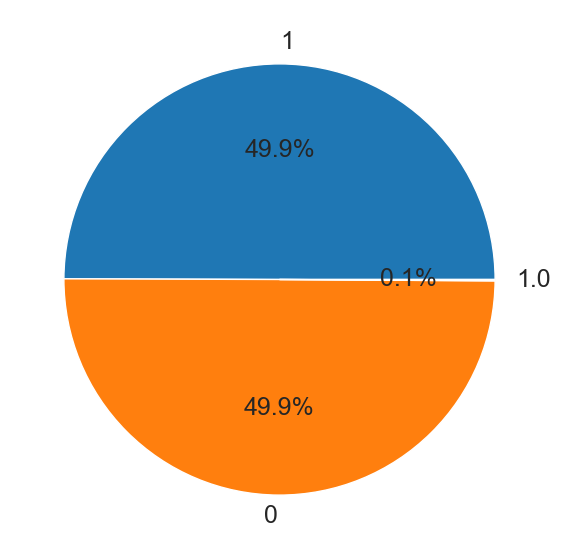

In [20]:
plt.pie(yelp['sentiment'].value_counts(), labels=yelp['sentiment'].unique().tolist(),autopct='%1.1f%%')
plt.show()

In [40]:
def visualize(col):
    
    plt.subplot(1,len(yelp.columns.tolist()[2:]),1)
    sns.boxplot(y=yelp[col])
    plt.ylabel(col, labelpad=12.5)
    
    plt.subplot(1,2,2)
    sns.boxplot(y=yelp[col])
#     sns.kdeplot(data = yelp, x=col,hue ='sentiment')
#     plt.legend(yelp['sentiment'].unique())
#     plt.xlabel('')
#     plt.ylabel('')
    
    plt.show()

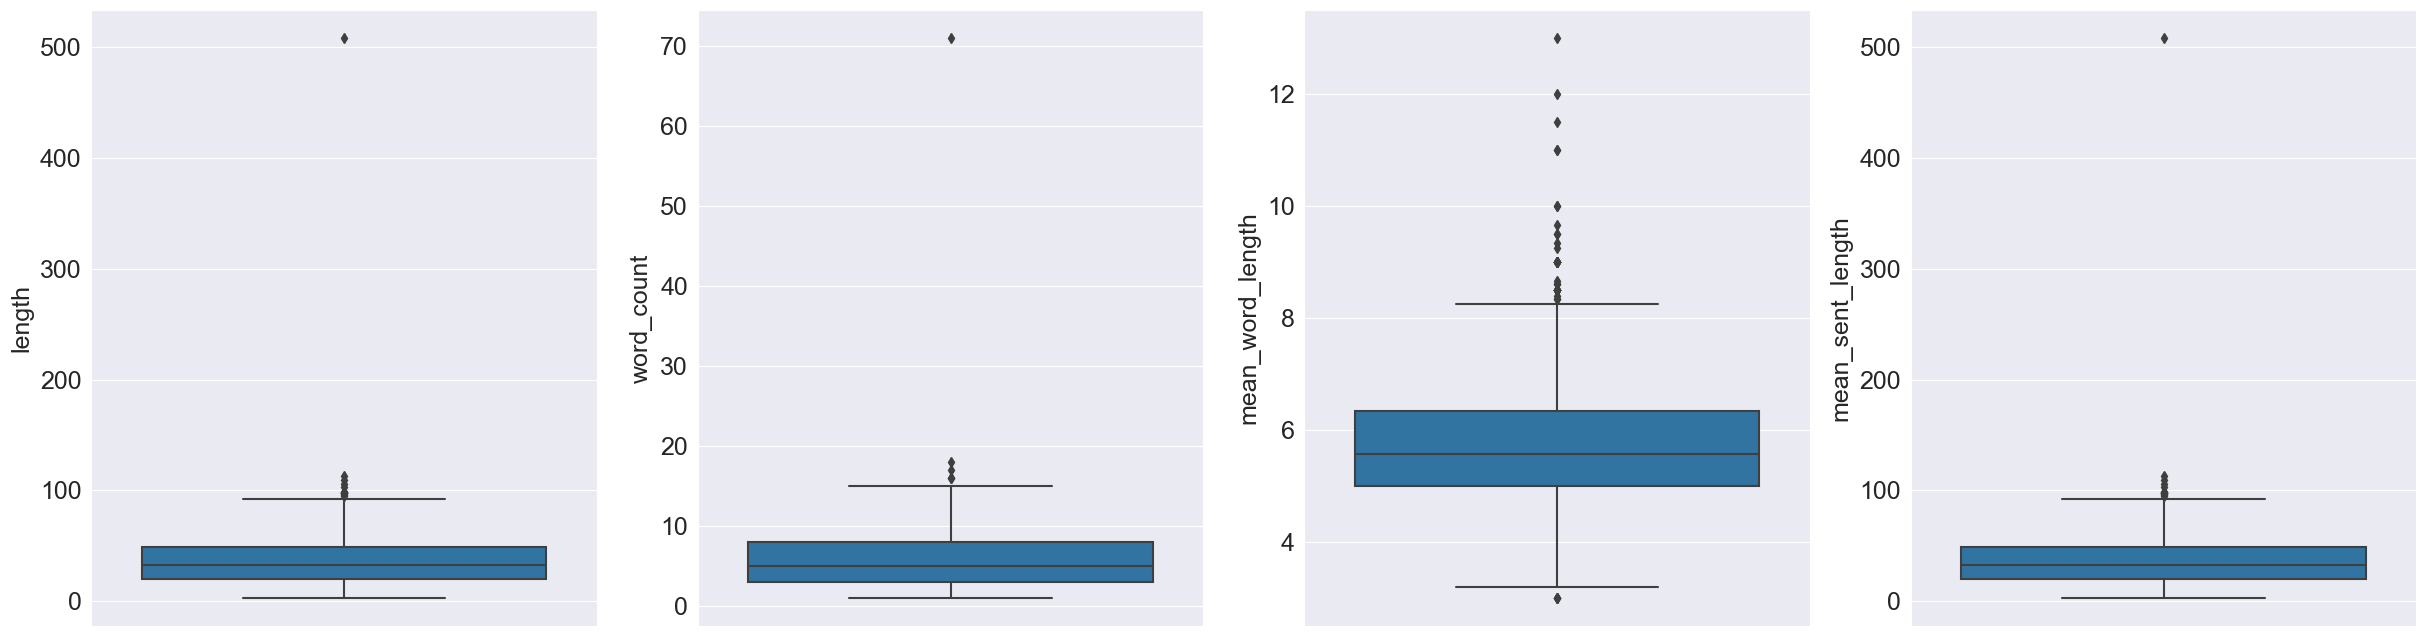

In [63]:
l_col =  yelp.columns.tolist()[2:-1]
plt.figure(figsize=(30,8))
for i in range(len(l_col)):
    plt.subplot(1,len(l_col),i+1)
    sns.boxplot(y=yelp[l_col[i]])
    plt.ylabel(l_col[i], labelpad=5)


In [23]:
corpus = []

In [24]:
yelp['comments'][0]

'wow loved place'

In [25]:
def corpus_func(text):
    text_list = text.split()
    return text_list

In [26]:
yelp['comments'][0].split()

['wow', 'loved', 'place']

In [27]:
yelp['comment_list'] = yelp['comments'].apply(corpus_func)

In [28]:
for i in trange(yelp.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += yelp['comment_list'][i]
len(corpus)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 989/989 [00:00<00:00, 141276.71it/s]


5702

In [29]:
most_common = Counter(corpus).most_common(10)
most_common

[('food', 123),
 ('place', 106),
 ('good', 95),
 ('service', 83),
 ('great', 69),
 ('back', 61),
 ('like', 46),
 ('go', 43),
 ('time', 42),
 ('really', 35)]

In [30]:
words = []
freq = []
for word, count in most_common:
    words.append(word)
    freq.append(count)


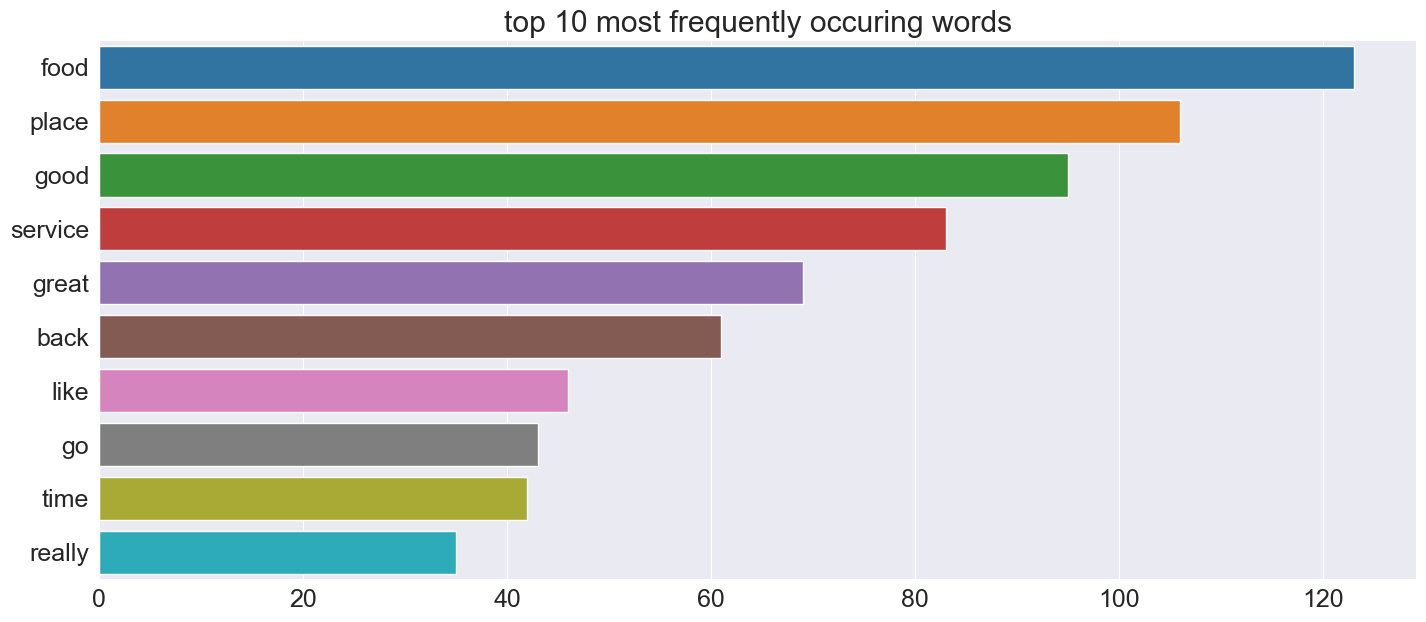

In [31]:
sns.barplot(x=freq, y=words)
plt.title('top 10 most frequently occuring words')
plt.show()

In [32]:
cv = CountVectorizer(ngram_range=(2, 2))
bigrams = cv.fit_transform(yelp['comments'])

In [33]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse=True))
ngram_freq.columns = ['frequency', 'ngram']

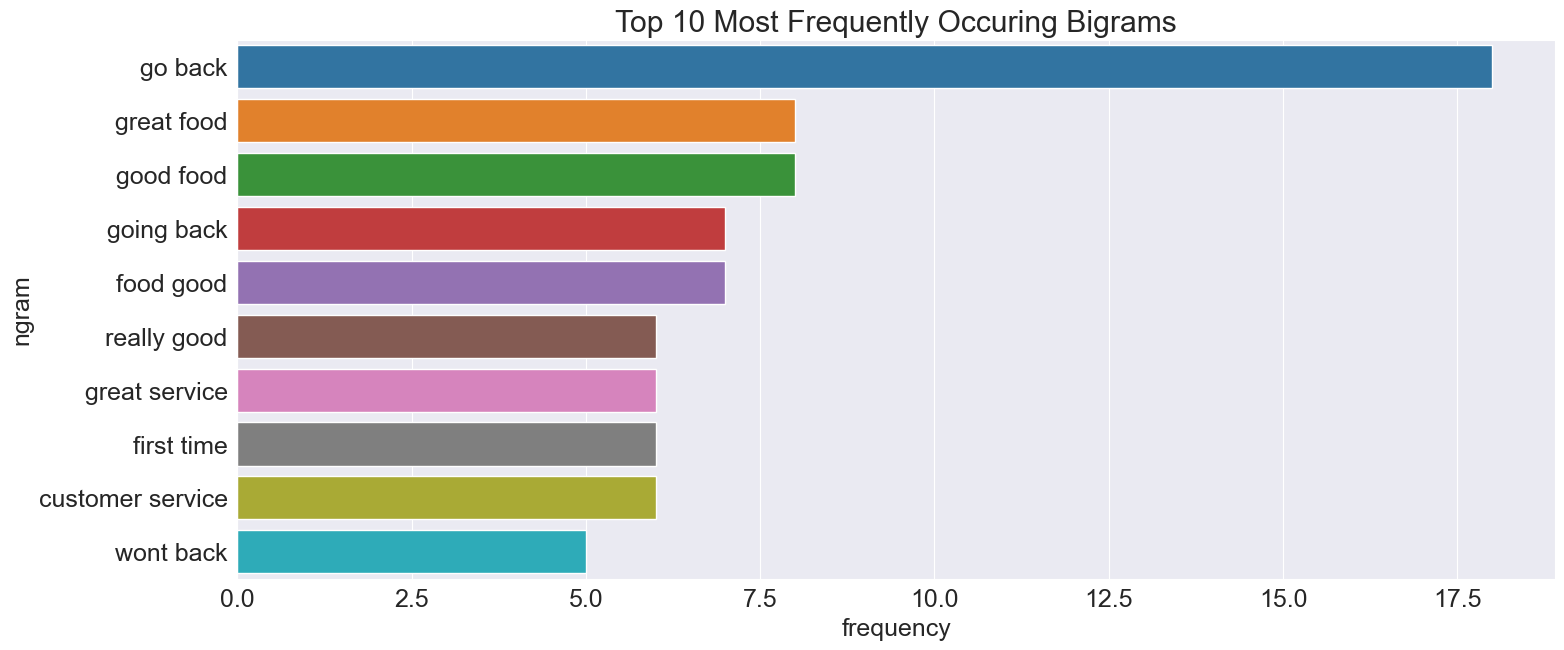

In [34]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

In [35]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(yelp['comments'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

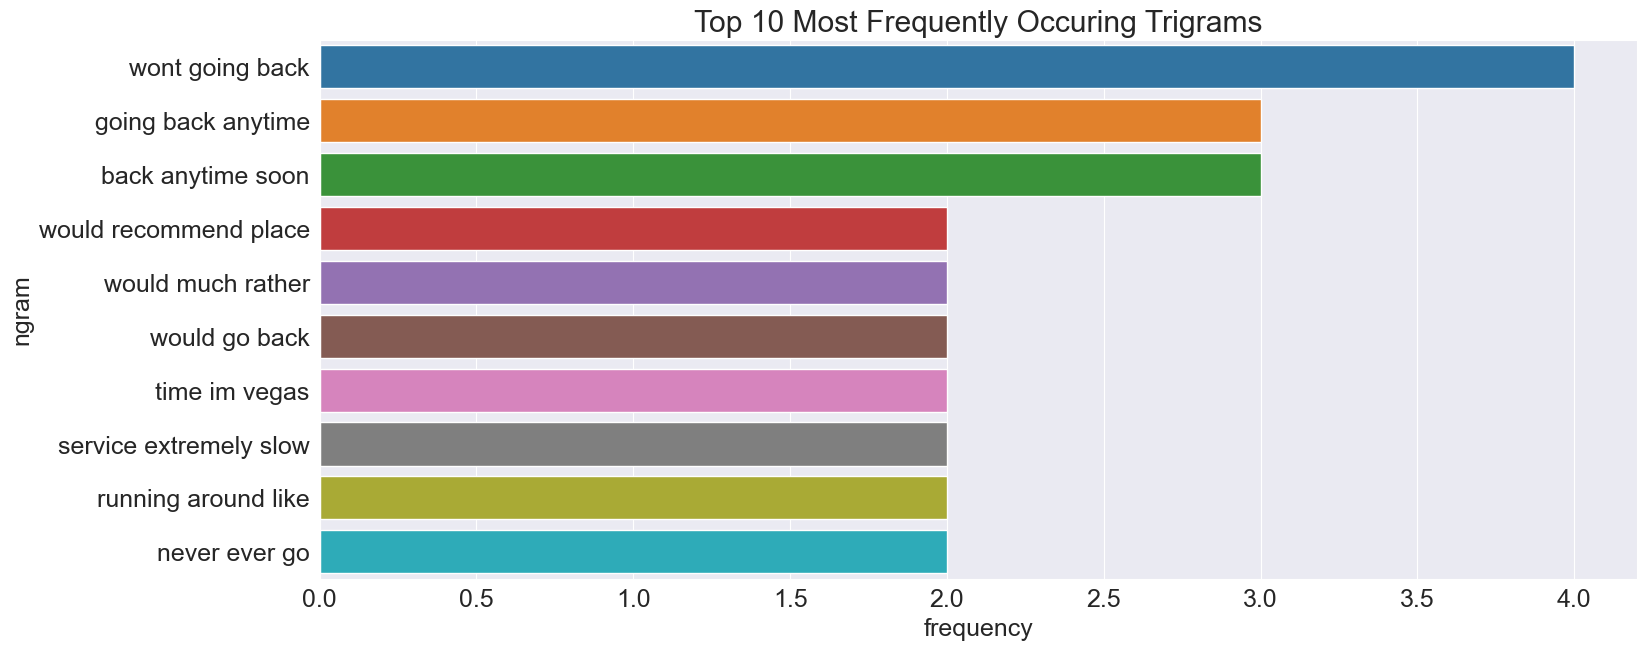

In [36]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams')
plt.show()

why did git hub give me an error?

In [37]:
ngram_freq

,frequency,ngram
0,4,wont going back
1,3,going back anytime
2,3,back anytime soon
3,2,would recommend place
4,2,would much rather
...,...,...
3699,1,12 mile brushfire
3700,1,1199 sandwich bigger
3701,1,100 times better
3702,1,10 times think


# Modeling

## Train Test Split

In [65]:
yelp.head()

,comments,sentiment,length,word_count,mean_word_length,mean_sent_length,comment_list
0,wow loved place,1,15,3,4.333333,15.0,"[wow, loved, place]"
1,crust good,0,10,2,4.500000,10.0,"[crust, good]"
2,tasty texture nasty,0,19,3,5.666667,19.0,"[tasty, texture, nasty]"
3,stopped late may bank holiday rick steve recom...,1,61,9,5.888889,61.0,"[stopped, late, may, bank, holiday, rick, stev..."
4,selection menu great prices,1,27,4,6.000000,27.0,"[selection, menu, great, prices]"


In [71]:
df = yelp[['comments', 'sentiment']]

In [72]:
df.head()

,comments,sentiment
0,wow loved place,1
1,crust good,0
2,tasty texture nasty,0
3,stopped late may bank holiday rick steve recom...,1
4,selection menu great prices,1


In [82]:
cv1 = CountVectorizer()
X = cv1.fit_transform(yelp['comments'])
y = yelp['sentiment']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)



In [90]:
model = MultinomialNB().fit(X_train, y_train)

In [93]:
model.predict_proba(X_test)[:,1]
model.score(X_test, y_test)

0.7828282828282829

In [114]:
str_want = pd.DataFrame(['dustin is a glorious hole'])
x_want = cv1.transform(str_want[0])

In [115]:
model.predict(x_want)

array(['1'], dtype='<U1')